In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # noqa: E402
import numpy as np
import seaborn as sns
import pandas as pd
import pickle

flist = matplotlib.font_manager.get_font_names()
from pathlib import Path  # noqa: E402

from extremeweatherbench import evaluate, calc, cases, defaults, inputs, metrics, regions, derived, utils

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

# ugly hack to load in our plotting scripts
import sys  # noqa: E402

sys.path.append(basepath + "/docs/notebooks/")
import paper_plotting as pp  # noqa: E402
import severe_convection_utils as severe_utils

In [3]:
# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()

# downselect to only the severe cases
ewb_cases = ewb_cases.select_cases("event_type", "severe_convection")

# build out all of the expected data to evalate the case (we need this so we can plot
# the LSR reports)
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)

loading in the events yaml file


In [4]:
# to plot the targets, we need to run the pipeline for each case and target
from joblib import Parallel, delayed  # noqa: E402
from joblib.externals.loky import get_reusable_executor  # noqa: E402

# load in all the case info (note this takes awhile in non-parallel form as it has to
# run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

print("running the pipeline for each case and target")
parallel = Parallel(n_jobs=32, return_as="generator", backend="loky")
case_operators_with_targets_established_generator = parallel(
    delayed(
        lambda co: (
            co.case_metadata.case_id_number,
            evaluate.run_pipeline(co.case_metadata, co.target),
        )
    )(case_operator)
    for case_operator in case_operators
)
case_operators_with_targets_established = list(
    case_operators_with_targets_established_generator
)
# this will throw a bunch of errors below but they're not consequential. this releases
# the memory as it shuts down the workers
get_reusable_executor().shutdown(wait=True)

running the pipeline for each case and target


In [5]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

ghcn_group_style = {'linestyle':'-', 'marker':'o', 'group':'GHCN'}
era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}

ifs_group_style = {'linestyle':'-', 'marker':'o', 'group':'IFS'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}

global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}

hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 

severe_tp_settings = {'linestyle':'-', 'marker':'o', 'group':'True Positives'}
severe_fn_settings = {'linestyle':'--', 'marker':'x', 'group':'False Negatives'}


In [6]:
# load the results back in
fourv2_severe_results = pd.read_pickle("gs://extremeweatherbench/tmp/fourv2_severe_results.pkl")
pang_severe_results = pd.read_pickle("gs://extremeweatherbench/tmp/pang_severe_results.pkl")
hres_severe_results = pd.read_pickle("gs://extremeweatherbench/tmp/hres_severe_results.pkl")
gc_severe_results = pd.read_pickle("gs://extremeweatherbench/tmp/gc_severe_results.pkl")


In [7]:
# loop through the results and find all the case studies that have non-zero results for each model
valid_case_ids = []
for case_id in hres_severe_results.case_id_number.unique():
    hres_subset = pp.subset_results_to_xarray(results_df=hres_severe_results, 
        forecast_source=hres_ifs_settings['forecast_source'], 
        target_source='local_storm_reports', metric='TruePositives', init_time='zeroz', case_id_list=[case_id])
    if hres_subset.value.sum() > 0:
        print(f'Case {case_id} has non-zero results for HRES')

        gc_subset = pp.subset_results_to_xarray(results_df=gc_severe_results, 
            forecast_source=gc_gfs_cira_settings['forecast_source'], 
            target_source='local_storm_reports', metric='TruePositives', init_time='zeroz', case_id_list=[case_id])
        if gc_subset.value.sum() > 0:
            print(f'Case {case_id} has non-zero results for GraphCast')

            pang_subset = pp.subset_results_to_xarray(results_df=pang_severe_results, 
                forecast_source=pangu_gfs_cira_settings['forecast_source'], 
                target_source='local_storm_reports', metric='TruePositives', init_time='zeroz', case_id_list=[case_id])
            if pang_subset.value.sum() > 0:
                print(f'Case {case_id} has non-zero results for Pangu')

                valid_case_ids.append(case_id)
                
print(valid_case_ids)

Case 257 has non-zero results for HRES
Case 261 has non-zero results for HRES
Case 262 has non-zero results for HRES
Case 264 has non-zero results for HRES
Case 265 has non-zero results for HRES
Case 266 has non-zero results for HRES
Case 267 has non-zero results for HRES
Case 268 has non-zero results for HRES
Case 269 has non-zero results for HRES
Case 269 has non-zero results for GraphCast
Case 269 has non-zero results for Pangu
Case 270 has non-zero results for HRES
Case 270 has non-zero results for GraphCast
Case 270 has non-zero results for Pangu
Case 271 has non-zero results for HRES
Case 271 has non-zero results for GraphCast
Case 271 has non-zero results for Pangu
Case 284 has non-zero results for HRES
Case 284 has non-zero results for GraphCast
Case 284 has non-zero results for Pangu
Case 285 has non-zero results for HRES
Case 285 has non-zero results for GraphCast
Case 285 has non-zero results for Pangu
Case 286 has non-zero results for HRES
Case 286 has non-zero results for 

In [8]:
from google.cloud import storage
storage_client = storage.Client()
bucket = storage_client.bucket("extremeweatherbench")

blob = bucket.blob("tmp/hres_graphics.pkl")
hres_graphics = pickle.load(blob.open("rb"))

blob = bucket.blob("tmp/gc_graphics.pkl")
gc_graphics = pickle.load(blob.open("rb"))

blob = bucket.blob("tmp/pang_graphics.pkl")
pang_graphics = pickle.load(blob.open("rb"))

blob = bucket.blob("tmp/fourv2_graphics.pkl")
fourv2_graphics = pickle.load(blob.open("rb"))


In [55]:
def get_lsr_from_case_op(my_case, case_operators_with_targets_established):
    for (id, case_info) in case_operators_with_targets_established:
        if id == my_case.case_id_number:
            if case_info.attrs["source"] == "local_storm_reports":
                return case_info
   
def plot_cbss_pph_panel(cbss, pph, my_case, lsrs, ax=None, title=None, lead_time_hours=0, gridlines_kwargs={}, geographic_features_kwargs={}):
    my_bbox = dict()
    my_bbox["latitude_min"] = my_case.location.latitude_min
    my_bbox["latitude_max"] = my_case.location.latitude_max
    my_bbox["longitude_min"] = my_case.location.longitude_min
    my_bbox["longitude_max"] = my_case.location.longitude_max

    # grab the valid time to plot
    valid_time = cbss.craven_brooks_significant_severe.valid_time
    my_pph = pph.sel(valid_time=valid_time).practically_perfect_hindcast.squeeze()

    lsrs = lsrs.sel(valid_time=valid_time)
    non_sparse_lsrs = utils.stack_dataarray_from_dims(
                        lsrs["report_type"], ["latitude", "longitude"]
                    ).squeeze()
    hail_data = non_sparse_lsrs[non_sparse_lsrs == 2]
    tornado_data = non_sparse_lsrs[non_sparse_lsrs == 3]
    hail_data = hail_data.to_dataframe().reset_index()
    tornado_data = tornado_data.to_dataframe().reset_index()
    ax, mappable = severe_utils.plot_cbss_forecast_panel(
        cbss_data=cbss.craven_brooks_significant_severe.squeeze(),
        target_date=my_case.start_date,
        lead_time_hours=lead_time_hours,
        bbox=my_bbox,
        ax=ax,
        pph_data=my_pph,
        tornado_reports=tornado_data,
        hail_reports=hail_data,
        title=title,
        alpha=0.6,
        gridlines_kwargs=gridlines_kwargs,
        geographic_features_kwargs=geographic_features_kwargs,
    )
    return ax, mappable

def get_stats(results, forecast_source, my_case, lead_time_hours=0):
    # list the statistics for each case
    tp_all = pp.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='local_storm_reports', metric='TruePositives', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    tp_mean = tp_all["value"].mean("case_id_number")
    lead_time_td = pd.Timedelta(hours=lead_time_hours)
    tp = tp_mean.sel(lead_time=lead_time_td, method="nearest")

    fn_all = pp.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='local_storm_reports', metric='FalseNegatives', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    fn_mean = fn_all["value"].mean("case_id_number")
    fn = fn_mean.sel(lead_time=lead_time_td, method="nearest")
    
    csi_all = pp.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='practically_perfect_hindcast', metric='CriticalSuccessIndex', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    csi_mean = csi_all["value"].mean("case_id_number")
    csi = csi_mean.sel(lead_time=lead_time_td, method="nearest")

    far_all = pp.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='practically_perfect_hindcast', metric='FalseAlarmRatio', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    far_mean = far_all["value"].mean("case_id_number")
    far = far_mean.sel(lead_time=lead_time_td, method="nearest")

    es_all = pp.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='practically_perfect_hindcast', metric='EarlySignal', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    es_mean = es_all["value"].mean("case_id_number")
    es = es_mean.sel(lead_time=lead_time_td, method="nearest")
    
    return [tp.values, fn.values, csi.values, far.values, es.values]

In [23]:
my_ids = [269, 270, 271, 284, 285, 286, 287, 288, 316, 317, 318, 319, 320, 321, 322, 323]
my_ids = [269, 318]

# plot all of the cases where we had all three models
for my_id in my_ids:
    print(my_id)
    my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]
    my_lsr = get_lsr_from_case_op(my_case, case_operators_with_targets_established)
    
    cbss_hres, pph_hres = hres_graphics[my_id, "cbss"], hres_graphics[my_id, "pph"]
    cbss_gc, pph_gc = gc_graphics[my_id, "cbss"], gc_graphics[my_id, "pph"]
    cbss_pang, pph_pang = pang_graphics[my_id, "cbss"], pang_graphics[my_id, "pph"]
    cbss_fourv2, pph_fourv2 = fourv2_graphics[my_id, "cbss"], fourv2_graphics[my_id, "pph"]

    # make a subplot for each model and ensure it is a cartopy plot
    fig, axs = plt.subplots(2, 4, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})

    plot_cbss_pph_panel(cbss_hres, pph_hres, my_case, lsrs=my_lsr, ax=axs[0,0], title="HRES", lead_time_hours=48)
    plot_cbss_pph_panel(cbss_gc, pph_gc, my_case, lsrs=my_lsr, ax=axs[0,1], title="GraphCast", lead_time_hours=48)
    plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, lsrs=my_lsr, ax=axs[0,2], title="Pangu", lead_time_hours=48)
    plot_cbss_pph_panel(cbss_fourv2, pph_fourv2, my_case, lsrs=my_lsr, ax=axs[0,3], title="FOURv2", lead_time_hours=48)


    # now plot the stats
    [tp, fn, csi, far, es] = get_stats(hres_severe_results, 
        hres_ifs_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,0].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,0].transAxes,
            ha='center', va='center')

    [tp, fn, csi, far, es] = get_stats(gc_severe_results, 
        gc_gfs_cira_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,1].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,1].transAxes,
            ha='center', va='center')

    [tp, fn, csi, far, es] = get_stats(pang_severe_results, 
        pangu_gfs_cira_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,2].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,2].transAxes,
            ha='center', va='center')

    [tp, fn, csi, far, es] = get_stats(fourv2_severe_results, 
        fourv2_gfs_cira_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,3].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,3].transAxes,
            ha='center', va='center')
    

    fig.suptitle(f"Case {my_id}")
    fig.savefig(basepath + f"saved_data/severe_case_{my_id}.png", dpi=300, bbox_inches="tight")


288


/tmp/ipykernel_10260/1022671924.py:19: UserWarning: Legend does not support handles for GeoContourSet instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axs[0].legend([n for n in list(axs[0].collections)], label_list, loc="upper right", fontsize=8)
/tmp/ipykernel_10260/1022671924.py:19: UserWarning: Legend does not support handles for FeatureArtist instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axs[0].legend([n for n in list(axs[0].collections)], label_list, loc="upper right", fontsize=8)


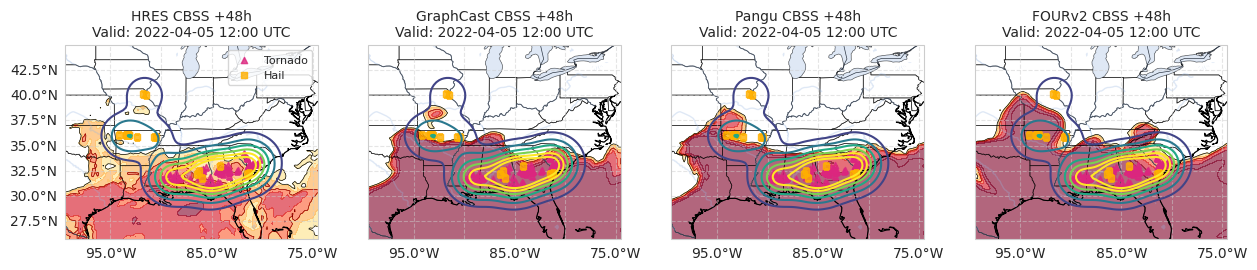

In [56]:
my_ids = [269, 270, 271, 284, 285, 286, 287, 288, 316, 317, 318, 319, 320, 321, 322, 323]
my_ids = [288]

# plot all of the cases where we had all three models
for my_id in my_ids:
    print(my_id)
    my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]
    my_lsr = get_lsr_from_case_op(my_case, case_operators_with_targets_established)
    
    cbss_hres, pph_hres = hres_graphics[my_id, "cbss"], hres_graphics[my_id, "pph"]
    cbss_gc, pph_gc = gc_graphics[my_id, "cbss"], gc_graphics[my_id, "pph"]
    cbss_pang, pph_pang = pang_graphics[my_id, "cbss"], pang_graphics[my_id, "pph"]
    cbss_fourv2, pph_fourv2 = fourv2_graphics[my_id, "cbss"], fourv2_graphics[my_id, "pph"]

    # make a subplot for each model and ensure it is a cartopy plot
    fig, axs = plt.subplots(1, 4, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    axs[0], _ = plot_cbss_pph_panel(cbss_hres, pph_hres, my_case, lsrs=my_lsr, ax=axs[0], title="HRES", lead_time_hours=48)

    # set up legend; this is rough but only last two are used.
    artist_list = [n for n in list(axs[0].collections)]
    label_list = [n.get_label() for n in artist_list]
    label_list[-2] = "Tornado"
    label_list[-1] = "Hail"
    axs[0].legend(artist_list, label_list, loc="upper right", fontsize=8)

    axs[1], _ = plot_cbss_pph_panel(cbss_gc, pph_gc, my_case, lsrs=my_lsr, ax=axs[1], title="GraphCast", lead_time_hours=48, gridlines_kwargs={"show_left_labels": False})
    axs[2], _ = plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, lsrs=my_lsr, ax=axs[2], title="Pangu", lead_time_hours=48, gridlines_kwargs={"show_left_labels": False})
    axs[3], _ = plot_cbss_pph_panel(cbss_fourv2, pph_fourv2, my_case, lsrs=my_lsr, ax=axs[3], title="FOURv2", lead_time_hours=48, gridlines_kwargs={"show_left_labels": False})
    
    #fig.suptitle(f"Case {my_id}")
    fig.savefig(basepath + f"saved_data/severe_case_{my_id}.png", dpi=300, bbox_inches="tight")


In [57]:
fig.savefig(basepath + f"saved_data/severe_case_{my_id}.png", dpi=300, bbox_inches="tight")
